In [2]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate

import os
import numpy as np 
import pandas as pd 
import imageio
import matplotlib.pyplot as plt

In [3]:
X=np.load('Vacamuerta_gray_scale.npy')
Y=np.load('Vacamuerta_binary.npy')
Xs=X[:,:,512:]
Ys=Y[:,:,512:]
Xn=Xs/np.max(Xs)
Yn=Ys-1
print ('Input shape',Xn.shape)
print ('Output shape:', Yn.shape)

Input shape (606, 512, 512)
Output shape: (606, 512, 512)


In [4]:
Xe = np.expand_dims(Xn, axis=3)
Ye = np.expand_dims(Yn, axis=3)

In [5]:
print ('Input shape',Xe.shape)
print ('Output shape:', Ye.shape)

Input shape (606, 512, 512, 1)
Output shape: (606, 512, 512, 1)


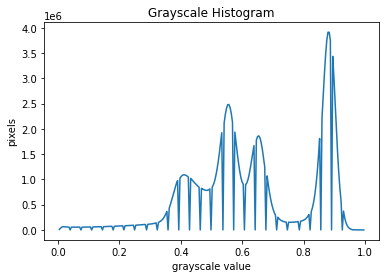

In [6]:
histogram, bin_edges = np.histogram(Xe, bins=256)

plt.figure()
plt.title("Grayscale Histogram")
plt.xlabel("grayscale value")
plt.ylabel("pixels")
#plt.xlim([0.0, 260])  # <- named arguments do not work here

plt.plot(bin_edges[0:-1], histogram)  # <- or here
plt.show()

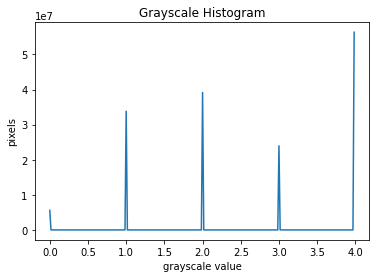

In [7]:
histogram, bin_edges = np.histogram(Ye, bins=256)

plt.figure()
plt.title("Grayscale Histogram")
plt.xlabel("grayscale value")
plt.ylabel("pixels")
#plt.xlim([0.0, 260])  # <- named arguments do not work here

plt.plot(bin_edges[0:-1], histogram)  # <- or here
plt.show()

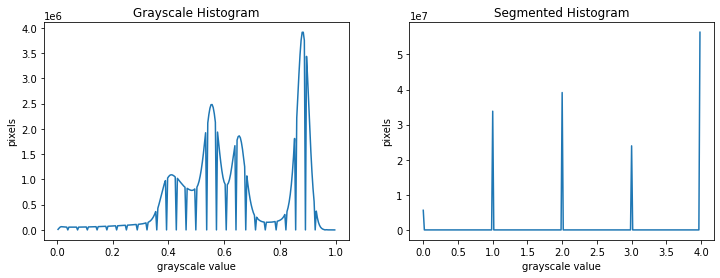

In [32]:
histogramx, bin_edgesx = np.histogram(Xe, bins=256)
histogram, bin_edges = np.histogram(Ye, bins=256)
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(121)
plt.title("Grayscale Histogram")
plt.xlabel("grayscale value")
plt.ylabel("pixels")
plt.plot(bin_edgesx[0:-1], histogramx)  # <- or here

ax2 = fig.add_subplot(122)
plt.title("Segmented Histogram")
plt.xlabel("grayscale value")
plt.ylabel("pixels")
plt.plot(bin_edges[0:-1], histogram)  # <- or here
plt.show()

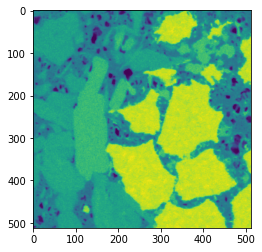

In [ ]:
mask1=Xe[100,:,:,:].reshape(512,512)
plt.imshow(mask1)

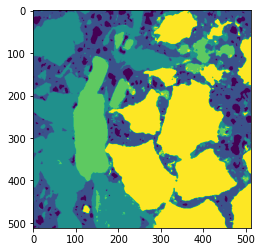

In [ ]:
mask2=Ye[100,:,:,:].reshape(512,512)
plt.imshow(mask2)

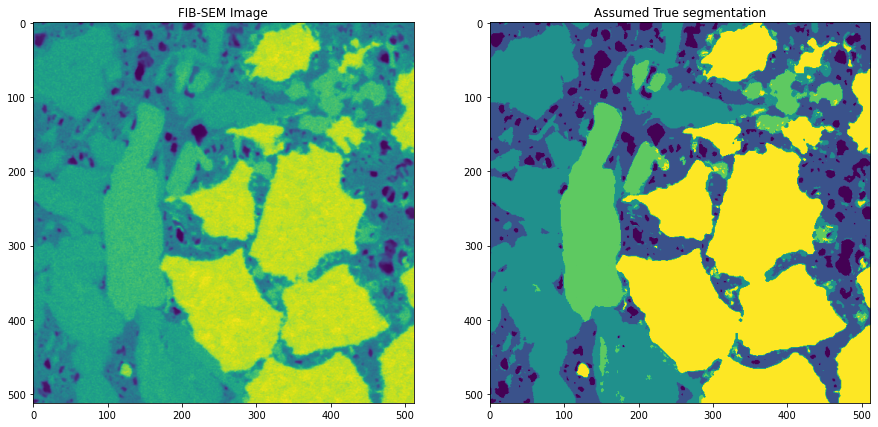

In [8]:
mask1=Xe[100,:,:,:].reshape(512,512)
mask2=Ye[100,:,:,:].reshape(512,512)
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(121)
plt.imshow(mask1)

ax2 = fig.add_subplot(122)
plt.imshow(mask2)


ax1.title.set_text('FIB-SEM Image')
ax2.title.set_text('Assumed True segmentation')
plt.show()

In [9]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(Xe,Ye, test_size=0.33, random_state=42)

In [10]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block
    
    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection outputs
    """
    conv = Conv2D(n_filters, # Number of filters
                 3,   # Kernel size   
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters, # Number of filters
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(conv)

    # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
         

    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        next_layer = MaxPooling2D((2, 2))(conv)
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

In [11]:
def upsampling_block(expansive_input, contractive_input, n_filters):
    """
    Convolutional upsampling block
    
    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns: 
        conv -- Tensor output
    """
    up = Conv2DTranspose(
                 n_filters,    # number of filters
                 (3, 3),    # Kernel size
                 strides=(2, 2),
                 padding='same')(expansive_input)
    
    # Merge the previous output and the contractive_input
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,   # Number of filters
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters,  # Number of filters
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(conv)
    
    return conv

In [12]:
def unet_model(input_size, n_filters, n_classes):
    """
    Unet model
    
    Arguments:
        input_size -- Input shape 
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns: 
        model -- tf.keras.Model
    """
    inputs = Input(input_size)
    cblock1 = conv_block(inputs, n_filters)
    # Chain the first element of the output of each block to be the input of the next conv_block. 
    # Double the number of filters at each new step
    cblock2 = conv_block(cblock1[0], n_filters*2)
    cblock3 = conv_block(cblock2[0], n_filters*4)
    cblock4 = conv_block(cblock3[0], n_filters*8, dropout_prob=0.3) # Include a dropout of 0.3 for this layer
    # Include a dropout of 0.3 for this layer, and avoid the max_pooling layer
    cblock5 = conv_block(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False) 
    ublock6 = upsampling_block(cblock5[0], cblock4[1],n_filters*8)
    ublock7 = upsampling_block(ublock6,cblock3[1],n_filters*4)
    ublock8 = upsampling_block(ublock7,cblock2[1],n_filters*2)
    ublock9 = upsampling_block(ublock8,cblock1[1],n_filters)
    

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [13]:
img_height = 512
img_width = 512
num_channels = 1
n_filters=32
n_classes=5
input_size=(img_height,img_width,num_channels)

unet = unet_model(input_size=input_size, n_filters=n_filters, n_classes=n_classes)

In [14]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 256, 256, 32) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [15]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as K
K.clear_session()
model_checkpoint = ModelCheckpoint('weights_vacamuerta.h5', monitor='val_loss', save_best_only=True)
model_history = unet.fit(x_train, y_train, batch_size=1, epochs=25, verbose=1, shuffle=False,validation_split=0.1,callbacks=[model_checkpoint])

Epoch 1/25
365/365 [==============================] - 36s 99ms/step - loss: 0.1068 - accuracy: 0.9564 - val_loss: 0.1067 - val_accuracy: 0.9559
Epoch 2/25
365/365 [==============================] - 36s 98ms/step - loss: 0.1049 - accuracy: 0.9572 - val_loss: 0.1049 - val_accuracy: 0.9567
Epoch 3/25
365/365 [==============================] - 36s 99ms/step - loss: 0.1045 - accuracy: 0.9573 - val_loss: 0.1046 - val_accuracy: 0.9568
Epoch 4/25
365/365 [==============================] - 36s 98ms/step - loss: 0.1031 - accuracy: 0.9579 - val_loss: 0.1065 - val_accuracy: 0.9560
Epoch 5/25
365/365 [==============================] - 36s 99ms/step - loss: 0.1021 - accuracy: 0.9583 - val_loss: 0.1086 - val_accuracy: 0.9552
Epoch 6/25
365/365 [==============================] - 36s 98ms/step - loss: 0.0987 - accuracy: 0.9596 - val_loss: 0.1017 - val_accuracy: 0.9580
Epoch 7/25
365/365 [==============================] - 36s 98ms/step - loss: 0.1095 - accuracy: 0.9557 - val_loss: 0.1084 - val_accuracy:

In [19]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

Text(0, 0.5, 'Loss')

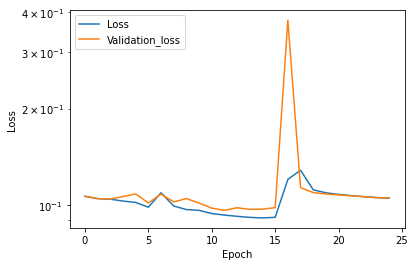

In [20]:
plt.plot(model_history.history["loss"],label='Loss')
plt.plot(model_history.history["val_loss"],label='Validation_loss')
plt.legend()
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [21]:
pred_mask = unet.predict(x_test)

In [22]:
pred_mask=np.array(pred_mask)

In [23]:
pred_mask.shape

(200, 512, 512, 5)

In [24]:
pred_mask_list=[]
for i in range (len(pred_mask)):
    out_mask=pred_mask[i,:,:,:]
    new_mask=tf.argmax(out_mask, axis=-1)
    pred_mask_list.append(new_mask)

In [25]:
pred_mask_list=np.array(pred_mask_list)

In [26]:
pred_mask_list.shape

(200, 512, 512)

In [56]:
n=199
pred_mask=pred_mask_list[n,:,:]
true_mask=y_test[n,:,:].reshape(512,512)
input_image=x_test[n,:,:].reshape(512,512)
diff=(pred_mask_list[n,:,:]-true_mask.reshape(512,512))

Text(0.5, 0, 'Test Image')

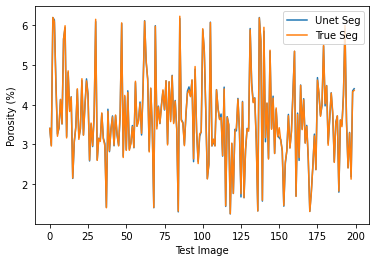

In [70]:
porosity_unet=[]
porosity_true=[]
for n in np.arange(0,200):
  pred_mask=pred_mask_list[n,:,:]
  true_mask=y_test[n,:,:].reshape(512,512)
  unique_elements_unet, counts_elements_unet = np.unique(pred_mask, return_counts=True)
  unique_elements_true, counts_elements_true = np.unique(true_mask, return_counts=True)
  por_unet=(counts_elements_unet[0]/np.sum(counts_elements_unet))*100
  por_true=(counts_elements_true[0]/np.sum(counts_elements_true))*100
  porosity_unet.append(por_unet)
  porosity_true.append(por_true)
  
plt.plot(np.arange(0,200),porosity_unet,label='Unet Seg')
plt.plot(np.arange(0,200),porosity_true,label='True Seg')
plt.legend()
plt.ylabel('Porosity (%)')
plt.xlabel('Test Image')

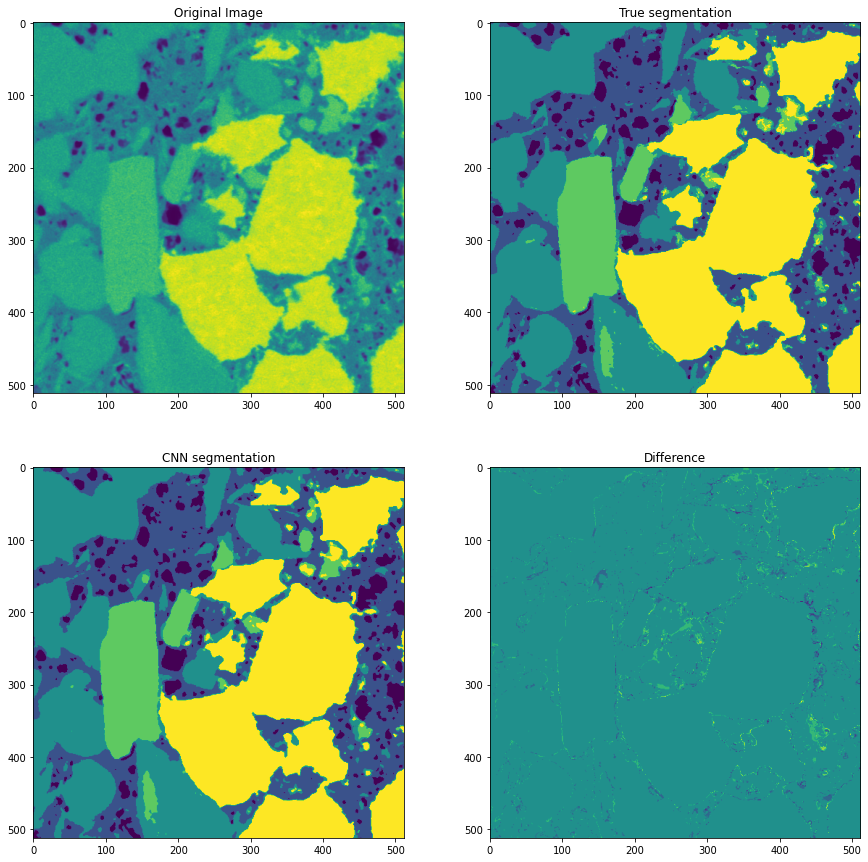

<Figure size 432x288 with 0 Axes>

In [31]:
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(221)
plt.imshow(input_image,cmap='viridis')

ax2 = fig.add_subplot(222)
plt.imshow(true_mask,cmap='viridis')

ax3 = fig.add_subplot(223)
plt.imshow(pred_mask,cmap='viridis')

ax4 = fig.add_subplot(224)
plt.imshow(diff,cmap='viridis')

ax1.title.set_text('Original Image')
ax2.title.set_text('True segmentation')
ax3.title.set_text('CNN segmentation')
ax4.title.set_text('Difference')
plt.show()
plt.savefig('Sample_CNN_5_cat_29.png')
